In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
from sklearn.preprocessing import MultiLabelBinarizer

### Dataset Update
- Original dataset: `support_tickets.csv` (synthetic data)
- Current dataset: `tickets.csv` (realistic ChatGPT-generated data)
- Analysis below reflects the realistic dataset

In [5]:
# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the data
df = pd.read_csv('../data/raw/tickets.csv')
print("Data loaded successfully!")
print(f"Shape: {df.shape}")
print("=== BASIC DATA INFO ===")
print(f"DATSET shape: {df.shape}")
print(f"Columns: [df.columns.tolist()]")
print("\nFirst 5 rows:")
print(df.head())

print("\n=== DATA TYPES ===")
print(df.dtypes)
print(f"\nMissing values: \n{df.isnull().sum()}")

Data loaded successfully!
Shape: (1000, 2)
=== BASIC DATA INFO ===
DATSET shape: (1000, 2)
Columns: [df.columns.tolist()]

First 5 rows:
                                                text            categories
0  My payment was processed twice, and I only ord...     ['Billing Issue']
1  I forgot my password and can't get back into m...    ['Account Access']
2  The product I received doesn't match the descr...   ['Product Inquiry']
3  I tried to update my shipping address but it k...  ['Shipping Concern']
4  I requested a refund two weeks ago and still h...    ['Refund Request']

=== DATA TYPES ===
text          object
categories    object
dtype: object

Missing values: 
text          0
categories    0
dtype: int64


In [6]:
# Convert categories string to list
if isinstance(df['categories'].iloc[0], str):
    df['categories'] = df['categories'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

print("\n=== SAMPLE TICKETS ===")
for i in range(3):
    print(f"\nTicket {i+1}:")
    print(f"Categories: {df['categories'].iloc[i]}")
    print(f"Text: {df['text'].iloc[i][:200]}...")



=== SAMPLE TICKETS ===

Ticket 1:
Categories: ['Billing Issue']
Text: My payment was processed twice, and I only ordered once....

Ticket 2:
Categories: ['Account Access']
Text: I forgot my password and can't get back into my account....

Ticket 3:
Categories: ['Product Inquiry']
Text: The product I received doesn't match the description on your website....



=== TEXT STATISTICS ===
Average text length: 73.98 characters
Average word count: 13.41 words
Min text length: 29
Max text length: 171


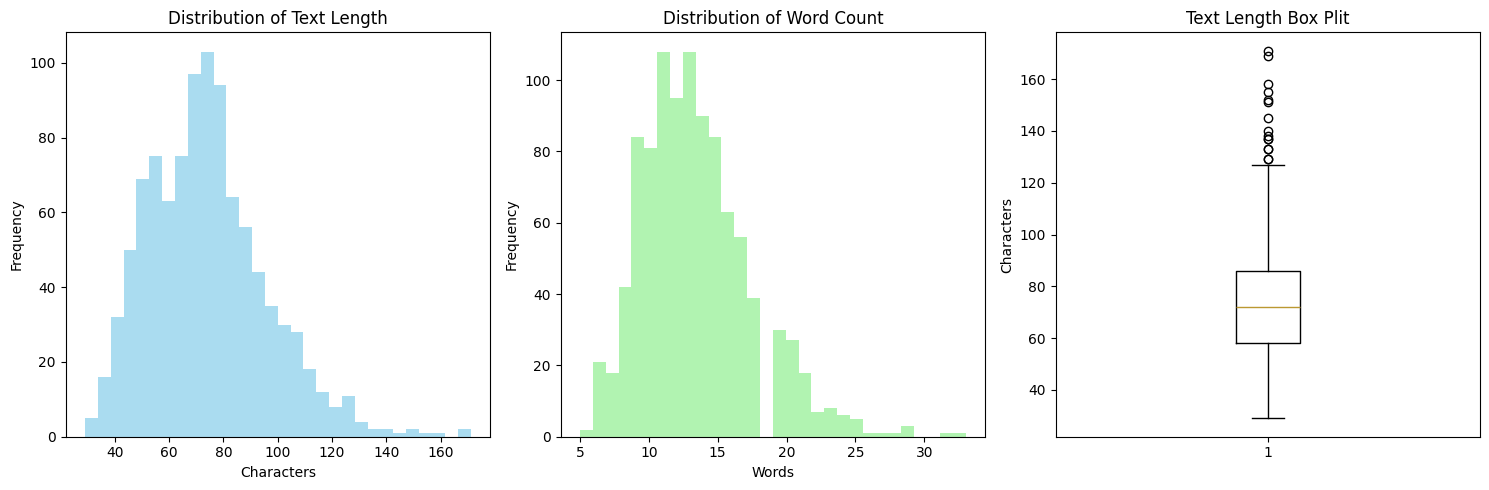

In [7]:
#Text statistics
print("\n=== TEXT STATISTICS ===")
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print(f"Average text length: {df['text_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")
print(f"Min text length: {df['text_length'].min()}")
print(f"Max text length: {df['text_length'].max()}")

#Plot text length distribution
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(df['text_length'], bins=30, alpha=0.7, color='skyblue')
plt.title('Distribution of Text Length')
plt.xlabel('Characters')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
plt.hist(df['word_count'], bins=30, alpha=0.7, color='lightgreen')
plt.title('Distribution of Word Count')
plt.xlabel('Words')
plt.ylabel('Frequency')


plt.subplot(1,3,3)
plt.boxplot(df['text_length'])
plt.title('Text Length Box Plit')
plt.ylabel('Characters')

plt.tight_layout()
plt.show()



=== CATEGORY ANALYSIS ===
Number of categories pet ticket:
num_categories
1    582
2    414
3      4
Name: count, dtype: int64

Category frequencies:
Billing Issue:288 (28.8%)
Technical Problem:280 (28.0%)
Shipping Concern:256 (25.6%)
Account Access:228 (22.8%)
Refund Request:180 (18.0%)
Product Inquiry:140 (14.0%)
Service Complaint:50 (5.0%)


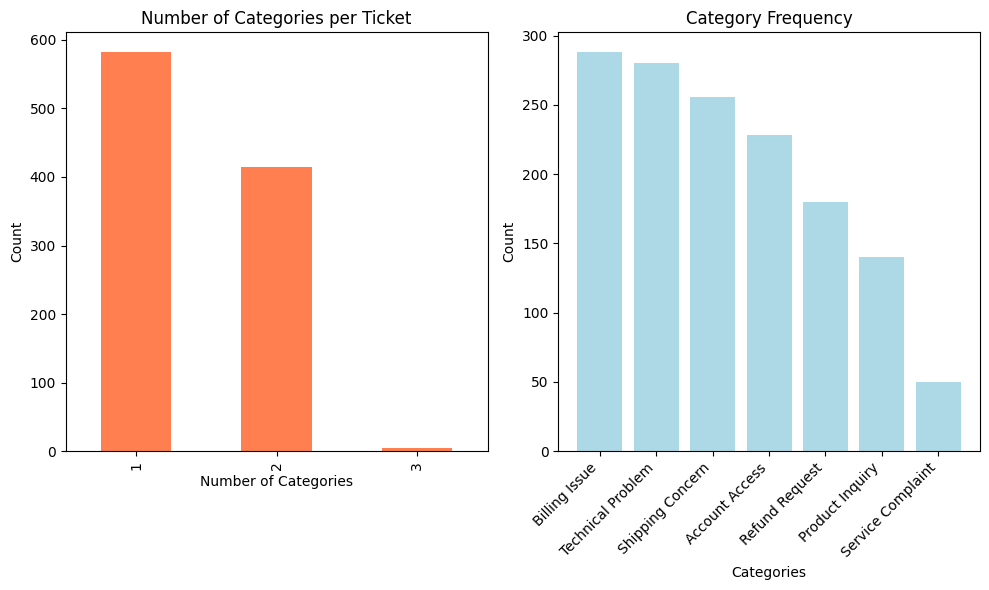

In [8]:
# Category Analysis
print("\n=== CATEGORY ANALYSIS ===")

# Count labels per ticket
df['num_categories'] = df['categories'].apply(len)
print(f"Number of categories pet ticket:")
print(df['num_categories'].value_counts().sort_index())

# plot categories per ticket
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
df['num_categories'].value_counts().sort_index().plot(kind='bar', color ='coral')
plt.title('Number of Categories per Ticket')
plt.xlabel('Number of Categories')
plt.ylabel('Count')


# Flatten all categories to count frequency
all_categories = [cat for categories in df['categories'] for cat in categories]
category_counts = Counter(all_categories)


print(f"\nCategory frequencies:")
for cat, count in category_counts.most_common():
    print(f"{cat}:{count} ({count/len(df)*100:.1f}%)")


# Plot category frequencies
plt.subplot(1,2,2)
categories, counts = zip(*category_counts.most_common())
plt.bar(range(len(categories)), counts, color = "lightblue")
plt.title('Category Frequency')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(range(len(categories)), categories, rotation=45, ha='right')
plt.tight_layout()
plt.show()




=== MULTI-LABEL COMBINATIONS ===
Label correlation matrix:
                   Account Access  Billing Issue  Product Inquiry  \
Account Access              1.000         -0.198           -0.219   
Billing Issue              -0.198          1.000           -0.250   
Product Inquiry            -0.219         -0.250            1.000   
Refund Request             -0.205          0.058           -0.024   
Service Complaint          -0.048         -0.136           -0.040   
Shipping Concern           -0.291         -0.247           -0.025   
Technical Problem           0.017         -0.003           -0.181   

                   Refund Request  Service Complaint  Shipping Concern  \
Account Access             -0.205             -0.048            -0.291   
Billing Issue               0.058             -0.136            -0.247   
Product Inquiry            -0.024             -0.040            -0.025   
Refund Request              1.000             -0.084            -0.150   
Service Complaint

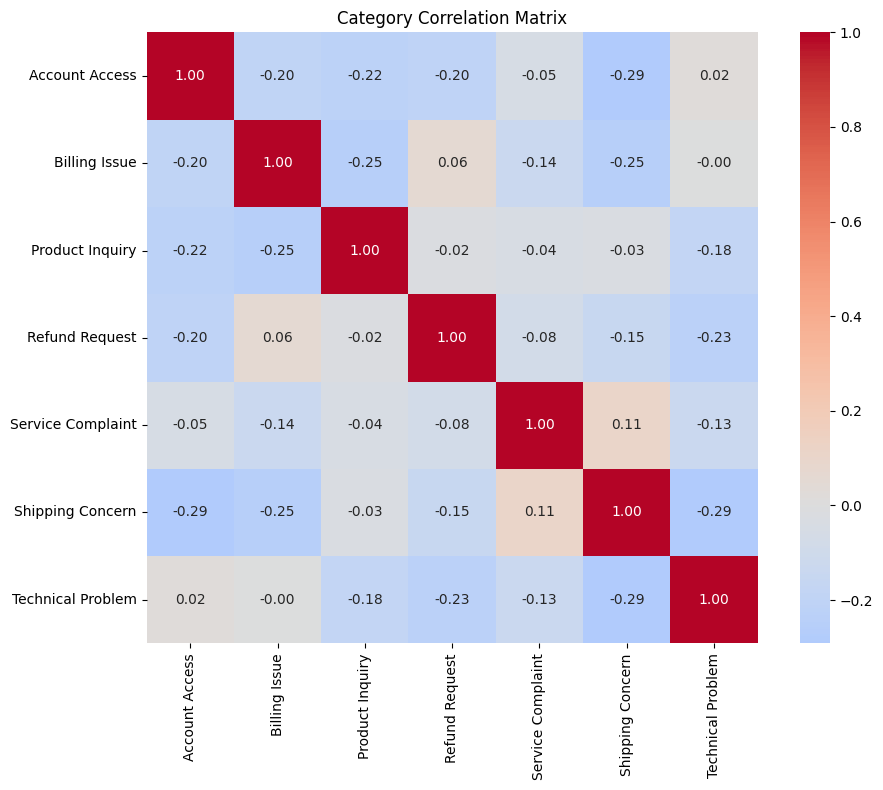


Top 10 most common category combination:
('Shipping Concern',): 138
('Account Access',): 114
('Technical Problem',): 96
('Billing Issue',): 95
('Billing Issue', 'Technical Problem'): 79
('Product Inquiry',): 70
('Account Access', 'Technical Problem'): 66
('Billing Issue', 'Refund Request'): 59
('Refund Request',): 57
('Product Inquiry', 'Shipping Concern'): 32


In [9]:
# Multi-label combination analysis
print("\n=== MULTI-LABEL COMBINATIONS ===")

# Convert to binary matrix for analysis
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(df['categories'])
label_df = pd.DataFrame(binary_labels, columns=mlb.classes_)

print("Label correlation matrix:")
correlation_matrix = label_df.corr()
print(correlation_matrix.round(3))


# Plot correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Category Correlation Matrix')
plt.tight_layout()
plt.show()


# Most common label combinations
combination_counts = df['categories'].apply(lambda x: tuple(sorted(x))).value_counts()
print(f"\nTop 10 most common category combination:")
for combo, count in combination_counts.head(10).items():
    print(f"{combo}: {count}")

In [10]:
# Data Quality checks
print("\n=== DATA QUALITY CHACKS ===")

# Check for empty texts
empty_texts = df[df['text'].str.strip() == ''].shape[0]
print(f"Empty texts: {empty_texts}")

# Check for tickets without categories
no_categories = df[df['categories'].apply(len) == 0].shape[0]
print(f"Tickets without categories: {no_categories}")

# Check for very short texts
short_texts = df[df['word_count'] < 5].shape[0]
print(f"very short texts (<5 words) :{short_texts}")

# Check for very long texts
long_texts = df[df['word_count'] > 200].shape[0]
print(f"Very long texts (>200 words): {long_texts}")



=== DATA QUALITY CHACKS ===
Empty texts: 0
Tickets without categories: 0
very short texts (<5 words) :0
Very long texts (>200 words): 0


In [11]:
# Summary statistics

print("\n=== SUMMARY STATISTICS ===")
print(f"Total tickets: {len(df)}")
print(f"Unique categories: {len(category_counts)}")
print(f"Average categories per ticket: {df['num_categories'].mean():.2f}")
print(f"Most common category: {category_counts.most_common(1)[0][0]} ({category_counts.most_common(1)[0][1]} occurrences)")
print(f"Least common category: {category_counts.most_common()[-1][0]} ({category_counts.most_common()[-1][1]} occurrences)")


=== SUMMARY STATISTICS ===
Total tickets: 1000
Unique categories: 7
Average categories per ticket: 1.42
Most common category: Billing Issue (288 occurrences)
Least common category: Service Complaint (50 occurrences)


In [12]:
# save processed insights
insights = {
    'total_tickets': len(df),
    'avg_text_length': df['text_length'].mean(),
    'avg_word_count': df['word_count'].mean(),
    'category distribution': dict(category_counts),
    'avg_categories_per_ticket': df['num_categories'].mean(),
    'data_quality': {
        'empty_texts': empty_texts,
        'no_categories' : no_categories,
        'short_texts': short_texts,
        'long_texts' : long_texts
    }
}

In [13]:
print("\n=== NEXT STEPS ===")
print("1. Data looks good for proceeding to preprocessing")
print("2. Consider text cleaning (remove special characters, normalize)")
print("3. Prepare train/validation/test splits")
print("4. Convert to proper format for multi-label classification")


=== NEXT STEPS ===
1. Data looks good for proceeding to preprocessing
2. Consider text cleaning (remove special characters, normalize)
3. Prepare train/validation/test splits
4. Convert to proper format for multi-label classification
